In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
def set_white_color(original_cmap):
    # Get the colors from the original colormap
    clrs = original_cmap(np.linspace(0, 1, original_cmap.N))
    # Set the first color to white
    clrs[0, :] = [1, 1, 1, 1] #RGBA values for white
    # Create a new colormap
    new_cmap = colors.ListedColormap(clrs)
    return(new_cmap)


def array_to_xarray(array,xarray):
    """
    scipy.ndimage converts xarray to array, this function reverts it back to xarray
    """
    new_xarray = xr.DataArray(
        array,
        dims=xarray.dims,  
        coords=xarray.coords,  
        attrs=xarray.attrs,
    )
    return new_xarray

def label_clusters(data_array, structure=None):
    """
    Defines clusters in data_array and labels it. Structure can be given to change how ndimage clusters points together.
    """
    labeled_array, num_features = ndimage.label(data_array.values, structure=structure) #num_features is ignored
    labeled_xarray = array_to_xarray(labeled_array,data_array)
    return labeled_xarray

def area_weights(data_array,latitude_dim_name='latitude',R = 6371):
    """
    Area of one grid cell (assuming spatial resolution is 0.25 x 0.25)
    """
    #R = 6371 km^2
    return (R**2)*np.deg2rad(0.25)*np.deg2rad(0.25)*np.cos(np.deg2rad(data_array[latitude_dim_name]))#np.cos(data_array[latitude_dim_name]*np.pi/180)

def label_and_filter(ds,mask_dim='mask',area_dim='areas',AREA_THRESHOLD=500000):
    """
    
    """
    ds['labeled_clusters'] = label_clusters(ds[mask_dim])
    ds["has_clusters"] = False
    clusters_label = np.unique(ds["labeled_clusters"].values)
    areas = ndimage.sum_labels(ds[area_dim],ds["labeled_clusters"],clusters_label)
    cluster_pd = pd.DataFrame({"label": clusters_label,"area": areas})
    cluster_pd = cluster_pd[cluster_pd['area']>AREA_THRESHOLD]
    cluster_pd = cluster_pd[cluster_pd['label']>0]
    if not cluster_pd.empty:
        cluster_pd = cluster_pd.reset_index()
        cluster_pd = cluster_pd.drop(['index'],axis=1,inplace=False)
        ds['labeled_clusters_filtered'] = ds['labeled_clusters']*ds['labeled_clusters'].isin(cluster_pd['label'])
        ds["has_clusters"] = True
    else:
        ds["labeled_clusters_filtered"]=np.minimum(ds["labeled_clusters"], 0)
    return ds

def get_cluster_info(ds,label_dim="labeled_clusters",label_filtered_dim='labeled_clusters_filtered',anomaly_dim="anomaly_scaled",area_dim='areas',time_dim='time'):
    #-------------------------
    clusters_label = np.unique(ds[label_filtered_dim].values)
    areas = ndimage.sum_labels(ds[area_dim],ds[label_dim],clusters_label)
    #-------------------------
    cluster_pd = pd.DataFrame({"label": clusters_label,"area": areas})
    cluster_pd = cluster_pd[cluster_pd['area']>AREA_THRESHOLD]
    cluster_pd = cluster_pd[cluster_pd['label']>0]
    cluster_pd = cluster_pd.reset_index()
    cluster_pd = cluster_pd.drop(['index'],axis=1,inplace=False)
    cluster_pd['time'] = ds[time_dim].values
    #-------------------------
    clusters_label = np.unique(cluster_pd['label'])
    minimum = ndimage.minimum(ds[anomaly_dim],ds[label_dim],clusters_label)
    stdev = ndimage.standard_deviation(ds[anomaly_dim],ds[label_dim],clusters_label)
    median = ndimage.median(ds[anomaly_dim],ds[label_dim],clusters_label)
    mean = ndimage.mean(ds[anomaly_dim],ds[label_dim],clusters_label)
    #-------------------------
    cm = ndimage.center_of_mass(ds[anomaly_dim].values,ds[label_dim].values,clusters_label)
    cluster_pd[['cm_lat','cm_lon']] = cm #center of mass returns (latitude,longitude)
    #-------------------------
    cluster_pd['mean']= mean
    cluster_pd['stdev']= stdev
    cluster_pd['median']= median
    cluster_pd['min_value']= minimum
    #-------------------------
    cmin = ndimage.minimum_position(ds[anomaly_dim].values,ds[label_dim].values,clusters_label)
    cluster_pd[['min_lat','min_lon']] = cmin #center of mass returns (latitude,longitude)
    cluster_pd['cm_lat'] = cluster_pd['cm_lat'].astype(int)
    cluster_pd['cm_lon'] = cluster_pd['cm_lon'].astype(int)

    return cluster_pd

def apply_binary_morph(data_array,s=np.ones((3,3)),method='dilation'):
    """
    Apply binary structure (s) to data_array using one of the methods available ['dilation','erosion','closing','fill_holes']
    data_array and s must have the same number of dimensions

    for future implementation:
    def simple_operation(a, b, operation):
    operations = {
        'divide'  : lambda a, b: a / b,
        'multiply': lambda a, b: a * b,
    }
    return operations.get(operation)(a, b)
    """
    if len(data_array.shape) != len(s.shape):
        print("No morphology change: data array and structure have different shapes")
        return(data_array)
    if method not in ['dilation','erosion','closing','fill_holes']:
        print("No morphology change: methods needs to be one of ['dilation','erosion','closing','fill_holes']")
        return(data_array)
    if method=='dilation':
        binary_transformation = ndimage.binary_dilation(data_array,structure=s).astype(int)
    elif method =='erosion':
        binary_transformation = ndimage.binary_erosion(data_array,structure=s).astype(int)
    elif method == 'closing':
        binary_transformation = ndimage.binary_closing(data_array,structure=s).astype(int)
    elif method == 'fill_holes':
        binary_transformation = ndimage.binary_fill_holes(data_array,structure=s).astype(int)
    return array_to_xarray(array=binary_transformation,xarray=data_array)

In [3]:
#PARAMETERS
STDEV_THRESHOLD = -1.5
AREA_THRESHOLD=500000#in km^2
VARIABLE = 'anomaly_scaled'
cmap_stdev = colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
z = [-3,-2,-1.5,-1,-0.5,0.5,1,1.5,2,3]
norm = colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))
new_cmap_viridis = set_white_color(plt.cm.viridis)
new_cmap_set1 = set_white_color(plt.cm.Set1)

In [4]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")

In [5]:
ds

<xarray.Dataset> Size: 46MB
Dimensions:         (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude        (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min    (time, latitude, longitude) float32 15MB ...
    anomaly         (time, latitude, longitude) float32 15MB ...
    anomaly_scaled  (time, latitude, longitude) float32 15MB ...

## mask by stdev threshold

In [6]:
ds["mask"] = ds[VARIABLE] <= STDEV_THRESHOLD

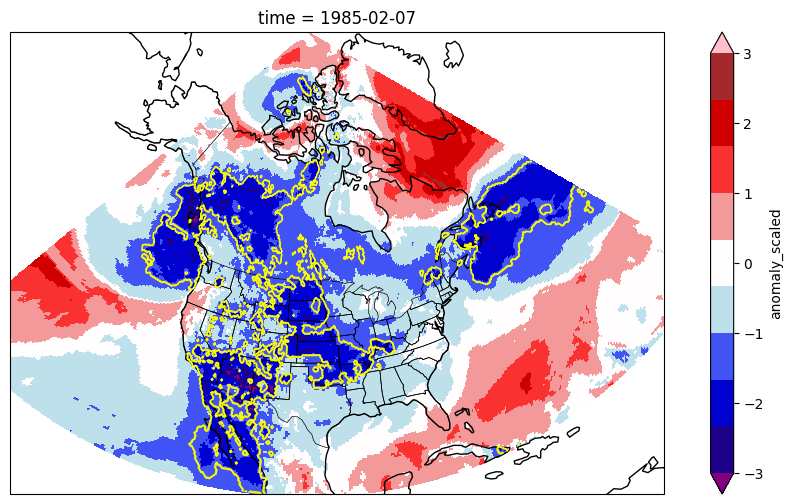

In [7]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['anomaly_scaled'].plot(transform=ccrs.PlateCarree(),cmap=cmap_stdev,norm=norm,levels=z,extend="both")
ds.sel(time='1985-02-07')['mask'].plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.5)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

Yellow contours highlighting clusters where scaled anomalies < -1.5C

## Label clusters and filter by area size

In [8]:
grid_areas = area_weights(ds['mask'])
ds['areas'] = grid_areas.broadcast_like(ds.isel(time=1))

In [9]:
ds=ds.groupby('time').map(label_and_filter)

In [10]:
list_df = list()
for t in ds.where(ds.has_clusters,drop=True).time.values:
    data_set = ds.sel(time=t)
    list_df.append(get_cluster_info(data_set))
#try to implement ds.where(ds.has_clusters,drop=True).groupby('time').map(get_cluster_info)    

In [11]:
cluster_info_df = pd.concat(list_df,axis=0)

In [13]:
#If is desired to keep timestamps with clusters, then:
#ds.where(ds.has_clusters,drop=True)

## Example: all labeled clusters

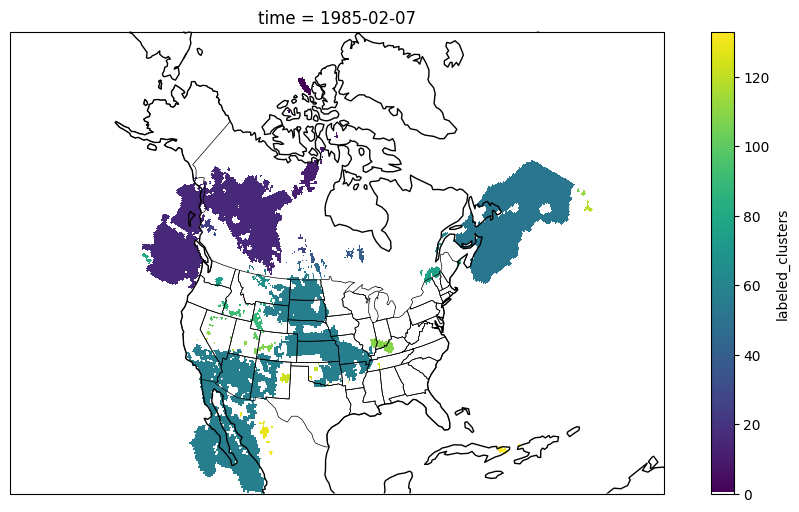

In [12]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Example: filtered labeled clusters

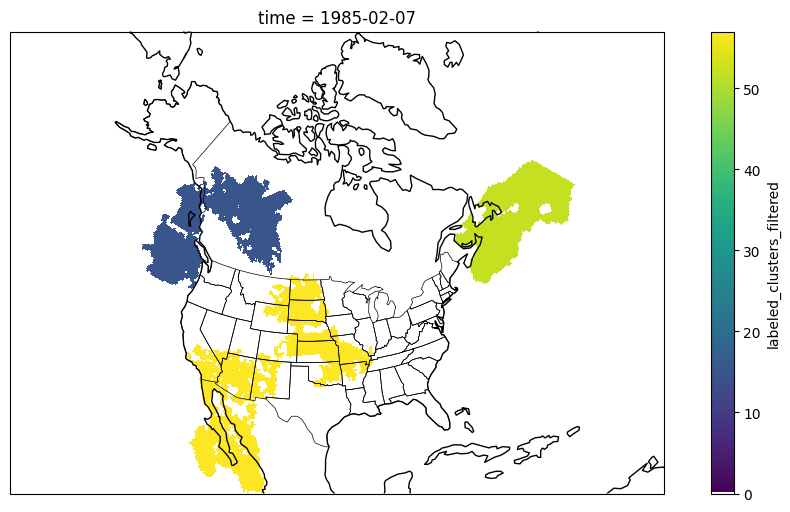

In [17]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters_filtered'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

In [16]:
#temp=ds[['labeled_clusters','area']].groupby(('time','labeled_clusters')).sum()
#temp['area'].to_pandas()

## Deforming clusters using binary masks

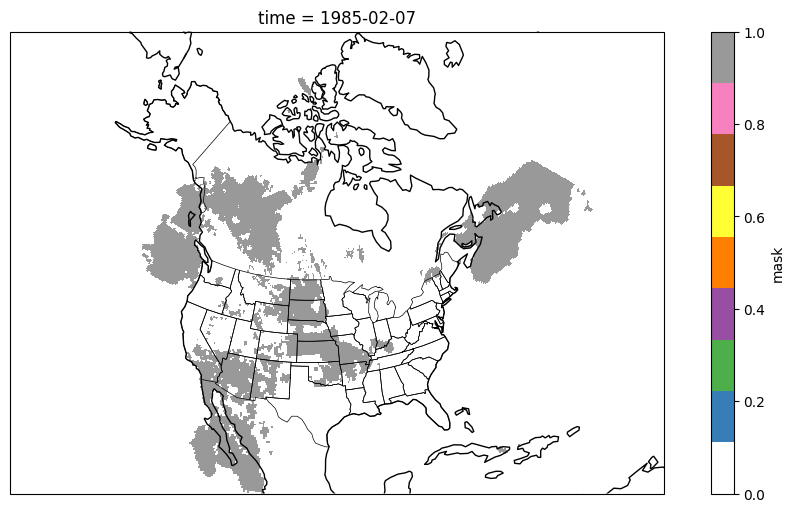

In [17]:
#Original
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds["mask"].sel(time='1985-02-07').plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

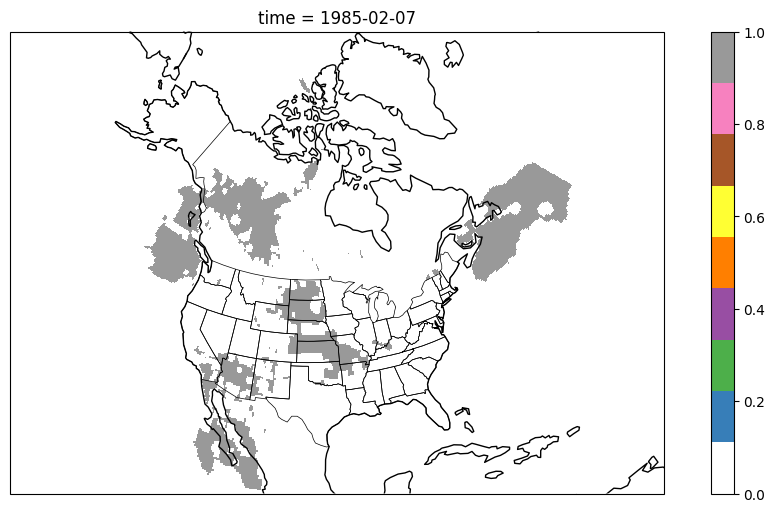

In [18]:
#Erosion
a=apply_binary_morph(ds["mask"].sel(time='1985-02-07'),method='erosion',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

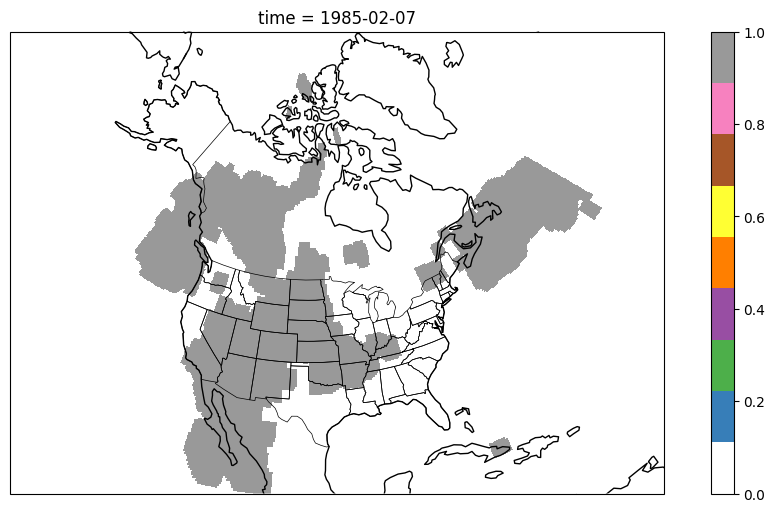

In [19]:
#Sequence of deformations
a = ds["mask"].sel(time='1985-02-07')
a=apply_binary_morph(a,method='closing',s=np.ones((3,3)))
a=apply_binary_morph(a,method='erosion',s=np.ones((2,2)))
a=apply_binary_morph(a,method='dilation',s=np.ones((9,9)))
a=apply_binary_morph(a,method='fill_holes',s=np.ones((7,7)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area coverage

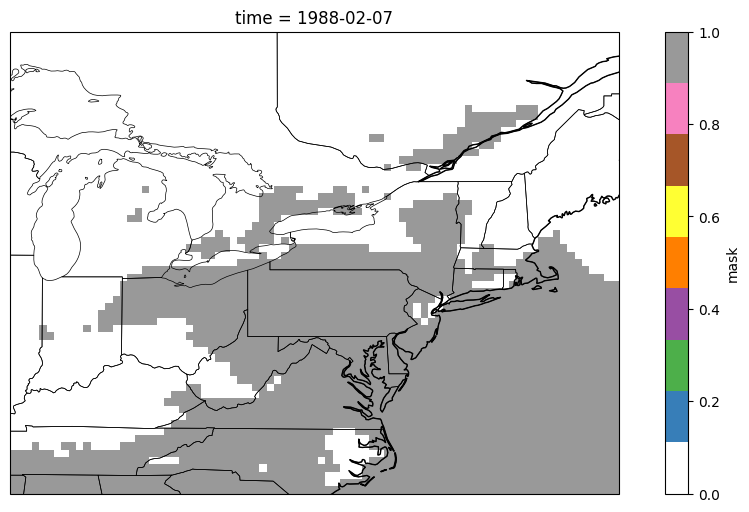

In [20]:
data_set = ds.sel(time='1988-02-07')
data_set = data_set.sel(latitude=slice(50, 34.5), longitude=slice(-88.5, -68))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['mask'].plot(cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

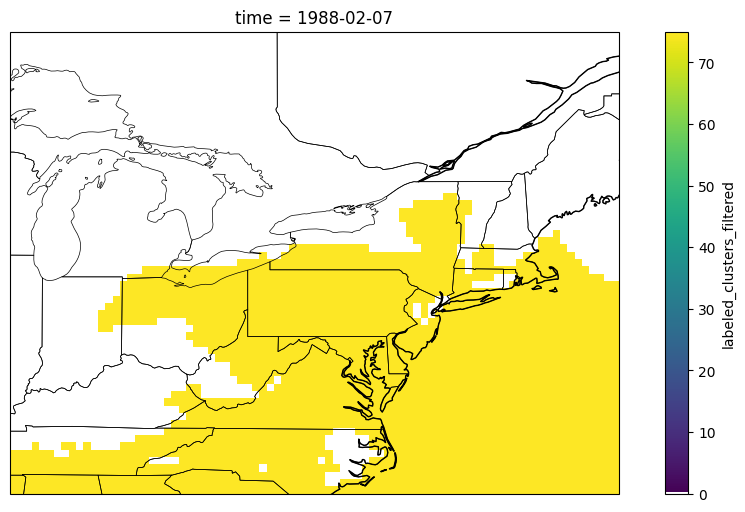

In [21]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['labeled_clusters_filtered'].plot(cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

In [22]:
#Total domain area
total_area = data_set['areas'] .sum()
data_set['areas_weight'] = data_set['areas']/total_area

total area under CAO 

In [23]:
#data_set.groupby('labeled_clusters_filtered').sum()['areas']
clusters_label = np.unique(data_set['labeled_clusters_filtered'])
clusters_label = clusters_label[clusters_label>0]
np.sum(ndimage.sum_labels(data_set['areas'],data_set["labeled_clusters"],clusters_label))

np.float64(1282627.7838113916)

total area where scaled anomaly is less than -1.5C

In [24]:
((data_set['mask'].astype(int) * data_set['areas']).sum()).values

array(1361989.56956476)

## Gaussian filter

In [25]:
def gaussian_filter(data_set,center_lon,center_lat,b=0.05,lat_dim_name="latitude",lon_dim_name="longitude"):
    
    X=data_set[lon_dim_name].broadcast_like(data_set)
    Y=data_set[lat_dim_name].broadcast_like(data_set)
    G = 1/(2*np.pi*b**2) * np.exp(-((np.deg2rad(Y)-np.deg2rad(center_lat))**2 + (np.deg2rad(X)-np.deg2rad(center_lon))**2)/(2*b**2))
    return(G)

In [26]:
data_set["G"] = gaussian_filter(data_set=data_set,center_lon = -75.6,center_lat = 42.9,b=0.18)
data_set['G']  = data_set['G']/np.max(data_set['G'])

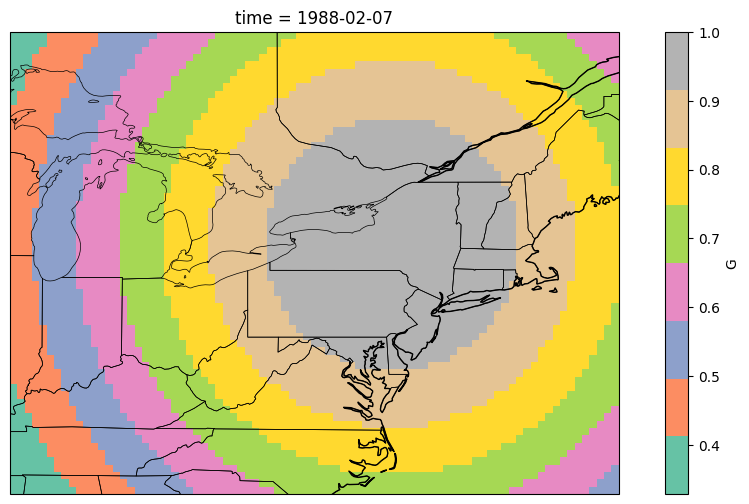

In [27]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['G'].plot(cmap='Set2')
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Area coverage using different filters

In [28]:
#Coverage by number of points
total_points = np.size(data_set.latitude) * np.size(data_set.longitude)
(np.sum(data_set['mask'])/total_points).values

array(0.4335437)

In [29]:
#Coverage weighted by area
total_area = np.sum(data_set['areas'])
(np.sum((data_set['areas']*data_set['mask']))/total_area).values

array(0.45678661)

In [30]:
#Coverage weighted by gaussian
total_gaussian = np.sum(data_set.G)
(np.sum((data_set['G']*data_set['mask']))/total_gaussian).values

array(0.45949623)

## Plot cluster center of mass

In [31]:
t = '1985-02-07'
data_set = ds.sel(time=t)
temp_info = cluster_info_df[cluster_info_df.time==t]
temp_info

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon
0,15,2.498608e+06,1985-02-07,139,104,-1.881232,0.283187,-1.817931,-3.160235,145,76
1,52,1.820119e+06,1985-02-07,180,391,-1.848057,0.225191,-1.813580,-2.552469,169,390
2,57,2.654647e+06,1985-02-07,216,178,-1.882571,0.310893,-1.816479,-3.487286,226,176


In [32]:
temp_info.cm_lon

0    104
1    391
2    178
Name: cm_lon, dtype: int64

In [33]:
lons = data_set.longitude.values[temp_info.cm_lon]
lats = data_set.latitude.values[temp_info.cm_lat]

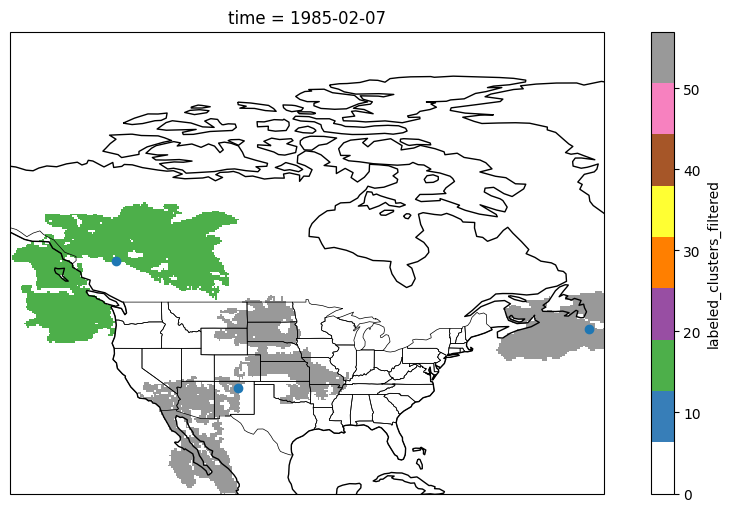

In [34]:
'''''
Testing center of mass coordinates
'''''
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['labeled_clusters_filtered'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
plt.scatter(lons,lats)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()